In [ ]:
import os
import cv2
import numpy as np

In [ ]:
zip_path = '/content/drive/MyDrive/Shop DataSet.zip'
extract_path = "shop data"

In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:

# المسار الكامل للفولدر
data_path = "/content/shop data/Shop DataSet"

# عرض محتويات الفولدر
print("Listing entries inside Shop DataSet:")
for item in os.listdir(data_path):
    print(item)


Listing entries inside Shop DataSet:
non shop lifters
shop lifters


In [ ]:
import os

# نشوف محتوى فولدر shop lifters
shop_lifters_path = os.path.join(data_path, "shop lifters")

print("Listing sample entries inside 'shop lifters':")
for item in os.listdir(shop_lifters_path)[:10]:
    print(item)


Listing sample entries inside 'shop lifters':
videppppsss_41.mp4
shop_lifter_98.mp4
videyyyyyyzzzzzyyyss_5.mp4
videmmmmmmsss_92.mp4
shop_lifter_87.mp4
shop_lifter_30.mp4
videppppsss_4.mp4
videmmmmmmsss_96.mp4
shop_lifter_2.mp4
videppppsss_44.mp4


In [ ]:
def load_video_frames(video_path, num_frames=60, resize=(112, 112)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # نختار فريمات بالتساوي على طول الفيديو
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()

    frames = np.array(frames)
    return frames  # shape: (num_frames, height, width, channels)


In [ ]:
sample_video = "/content/shop data/Shop DataSet/shop lifters/shop_lifter_106.mp4"
frames = load_video_frames(sample_video)

print("Frames shape:", frames.shape)


Frames shape: (60, 112, 112, 3)


In [ ]:
import random
import cv2
import numpy as np

def augment_video(frames):
    aug_frames = []
    for frame in frames:
        # Flip أفقي أحيانًا
        if random.random() < 0.5:
            frame = cv2.flip(frame, 1)

        # تغيير السطوع أحيانًا
        if random.random() < 0.5:
            value = random.randint(-30, 30)
            hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
            hsv[:, :, 2] = np.clip(hsv[:, :, 2].astype(int) + value, 0, 255).astype(np.uint8) # Fix: Ensure result is within uint8 range
            frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        # Rotation بسيطة
        if random.random() < 0.5:
            angle = random.uniform(-10, 10)
            h, w = frame.shape[:2]
            M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
            frame = cv2.warpAffine(frame, M, (w, h))

        aug_frames.append(frame)

    return np.array(aug_frames)

In [ ]:
aug_frames = augment_video(frames)
print("Augmented frames shape:", aug_frames.shape)


Augmented frames shape: (60, 112, 112, 3)


In [ ]:
import numpy as np

def process_videos_from_folder(folder_path, label, num_frames=60, resize=(112,112)):
    X, y = [], []
    for file in os.listdir(folder_path):
        if file.endswith(".mp4"):
            path = os.path.join(folder_path, file)
            frames = load_video_frames(path, num_frames=num_frames, resize=resize)
            frames = augment_video(frames)
            X.append(frames)
            y.append(label)
    return np.array(X), np.array(y)

# المسارات
shop_lifters_path = os.path.join(data_path, "shop lifters")
non_shop_lifters_path = os.path.join(data_path, "non shop lifters")

# تجهيز البيانات
X1, y1 = process_videos_from_folder(shop_lifters_path, 1, num_frames=60)
X0, y0 = process_videos_from_folder(non_shop_lifters_path, 0, num_frames=60)

# الدمج
X = np.concatenate([X0, X1])
y = np.concatenate([y0, y1])

print("✅ Data ready")
print("X shape:", X.shape)
print("y shape:", y.shape)


✅ Data ready
X shape: (855, 60, 112, 112, 3)
y shape: (855,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization

# بناء الموديل
model = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=(60, 112, 112, 3)),
    MaxPooling3D((2, 2, 2)),
    BatchNormalization(),

    Conv3D(64, (3, 3, 3), activation='relu'),
    MaxPooling3D((2, 2, 2)),
    BatchNormalization(),

    Conv3D(128, (3, 3, 3), activation='relu'),
    MaxPooling3D((2, 2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# إعداد الموديل للتدريب
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 58, 110, 110,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 29, 55, 55, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 55, 55, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 27, 53, 53, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 13, 26, 26, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 26, 26, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 11, 24, 24,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 5, 12, 12, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 12, 12, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 92160)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    23,593,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,873,665 (91.07 MB)

 Trainable params: 23,873,217 (91.07 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=4
)


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 47s 163ms/step - accuracy: 0.5726 - loss: 17.5898 - val_accuracy: 0.7251 - val_loss: 0.7580
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.5889 - loss: 0.6484 - val_accuracy: 0.6199 - val_loss: 0.5039
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.6449 - loss: 0.6270 - val_accuracy: 0.6316 - val_loss: 0.5433
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - accuracy: 0.6317 - loss: 0.6078 - val_accuracy: 0.9181 - val_loss: 0.4423
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.7336 - loss: 0.5070 - val_accuracy: 0.7251 - val_loss: 0.5547
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.7255 - loss: 0.4866 - val_accuracy: 0.9298 - val_loss: 0.3814
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.7375 - loss: 0.5090 - val_accuracy: 0.9298 - val_loss: 0.2969
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 24s 139ms/step - accuracy: 0.7725 - loss: 

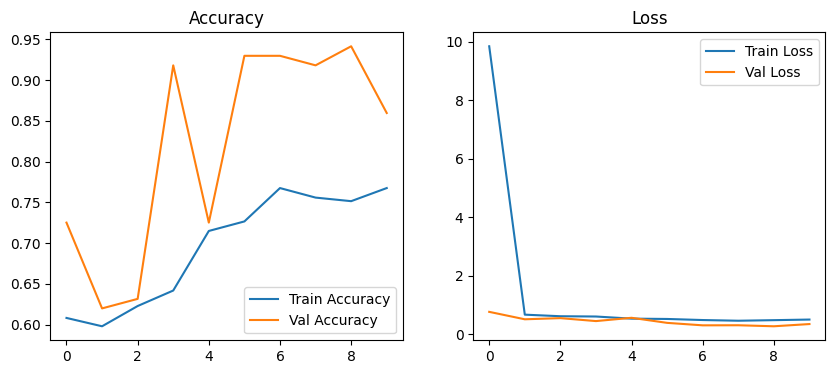

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# بناء الموديل
model = Sequential([
    Conv3D(32, (3,3,3), activation='relu', input_shape=(60, 112, 112, 3)),
    MaxPooling3D((2,2,2)),

    Conv3D(64, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D((2,2,2)),

    # طبقة إضافية
    Conv3D(128, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D((2,2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# تدريب الموديل
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=4,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms/step - accuracy: 0.5582 - loss: 22.9566 - val_accuracy: 0.7602 - val_loss: 0.6410
Epoch 2/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - accuracy: 0.7445 - loss: 0.5561 - val_accuracy: 0.8304 - val_loss: 0.4799
Epoch 3/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.8149 - loss: 0.4809 - val_accuracy: 0.8363 - val_loss: 0.4027
Epoch 4/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.8968 - loss: 0.2533 - val_accuracy: 0.7953 - val_loss: 0.3974
Epoch 5/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - accuracy: 0.9556 - loss: 0.1602 - val_accuracy: 0.9415 - val_loss: 0.2341
Epoch 6/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.9466 - loss: 0.1329 - val_accuracy: 0.9181 - val_loss: 0.2264
Epoch 7/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.9905 - loss: 0.0541 - val_accuracy: 0.9006 - val_loss: 0.2528
Epoch 8/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.9900 - loss: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# بناء الموديل
model = Sequential([
    Conv3D(32, (3,3,3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(60, 112, 112, 3)),
    BatchNormalization(),
    MaxPooling3D((2,2,2)),
    Dropout(0.25),

    Conv3D(64, (3,3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling3D((2,2,2)),
    Dropout(0.25),

    Conv3D(128, (3,3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling3D((2,2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# compile
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# تدريب الموديل
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=4,
    callbacks=[early_stop]
)


Epoch 1/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - accuracy: 0.5461 - loss: 2.4605 - val_accuracy: 0.6491 - val_loss: 1.1764
Epoch 2/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.6332 - loss: 1.4489 - val_accuracy: 0.8246 - val_loss: 1.1770
Epoch 3/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - accuracy: 0.7467 - loss: 1.1488 - val_accuracy: 0.9240 - val_loss: 1.0652
Epoch 4/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - accuracy: 0.7404 - loss: 1.1494 - val_accuracy: 0.9298 - val_loss: 1.0178
Epoch 5/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - accuracy: 0.7984 - loss: 1.0478 - val_accuracy: 0.9123 - val_loss: 1.0369
Epoch 6/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - accuracy: 0.8066 - loss: 1.0390 - val_accuracy: 0.9357 - val_loss: 0.9634
Epoch 7/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.8469 - loss: 0.9754 - val_accuracy: 0.9123 - val_loss: 0.9454
Epoch 8/40
171/171 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - accuracy: 0.8546 - loss: 0

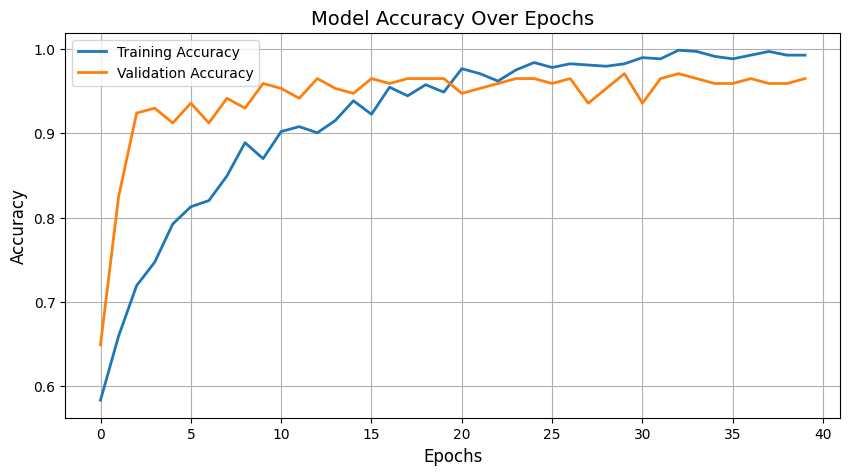

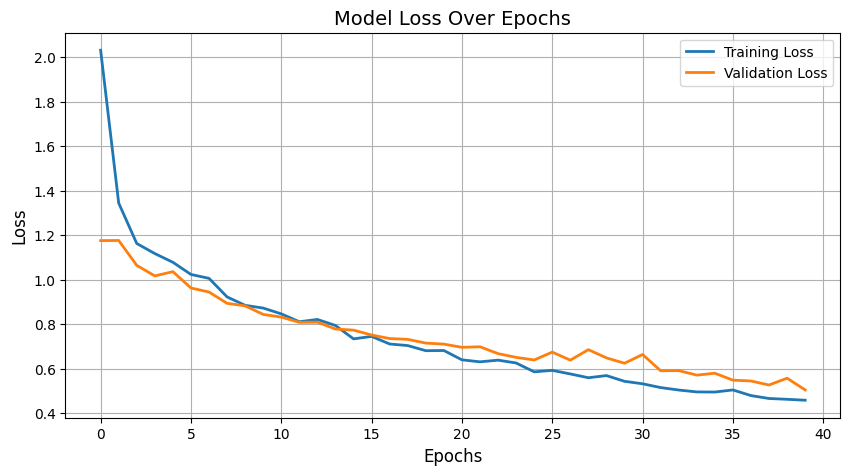

In [ ]:
import matplotlib.pyplot as plt

# رسم الدقة (Accuracy)
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# رسم الخسارة (Loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))


{np.int64(0): np.int64(531), np.int64(1): np.int64(324)}

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


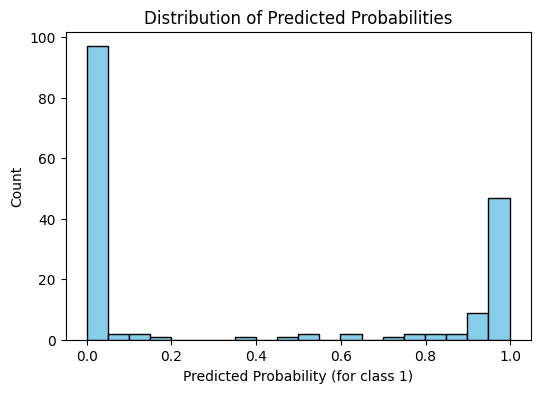

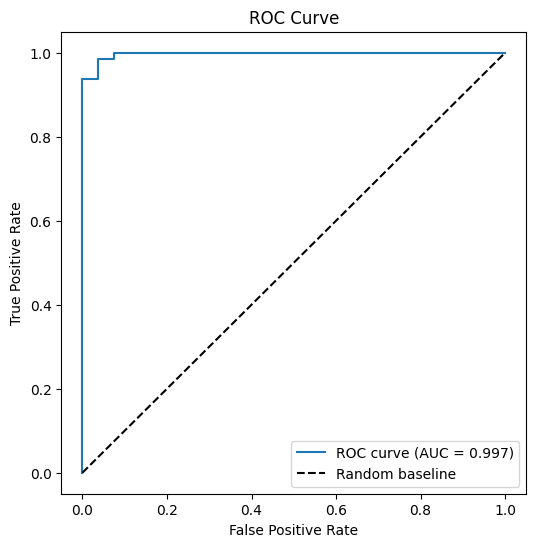

ROC-AUC Score: 0.997


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# نحسب التوقعات من الموديل
y_pred_proba = model.predict(X_test).ravel()

# نرسم توزيع التوقعات
plt.figure(figsize=(6,4))
plt.hist(y_pred_proba, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability (for class 1)")
plt.ylabel("Count")
plt.show()

# نحسب الـ ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# نعرض منحنى ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"ROC-AUC Score: {roc_auc:.3f}")

Optimal threshold: 0.495

Classification Report (with optimal threshold):
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       106
           1       0.94      0.98      0.96        65

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



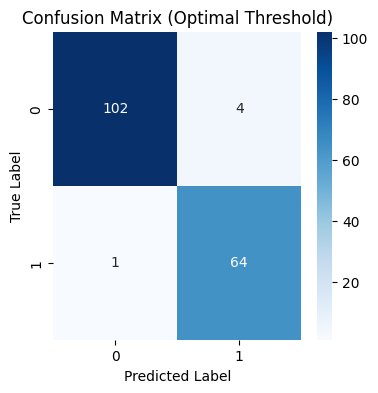

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# حساب أفضل threshold بناءً على توازن TPR و FPR
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.3f}")

# تطبيق threshold الجديد
y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)

# إعادة تقييم النموذج
print("\nClassification Report (with optimal threshold):")
print(classification_report(y_test, y_pred_opt))

# مصفوفة الالتباس
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Optimal Threshold)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()